In [1]:
import os 

os.environ["PYSPARK_PYTHON"]="python3.7"
os.environ["PYSPARK_DRIVER_PYTHON"]="python3.7"

In [2]:
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml import PipelineModel
spark = SparkSession \
        .builder \
        .master("spark://spark-master:7077") \
        .appName("Visualization") \
        .getOrCreate()

In [3]:

# df=spark.read.format("csv").option("mode", "FAILFAST")\
# .option("inferSchema", "true").load("hdfs://namenode/user/taipt/data.csv")  

df=spark.read.format('csv').options(header='true').option("inferSchema", "true")\
    .load("hdfs://namenode/user/taipt/data.csv")

In [4]:
df.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)



In [5]:
df.show()

+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|    22752|SET 7 BABUSHKA NE...|       2|12/1/2010 8:26|     7.65|     17850|United Kingdom|
|   536365|    21730|GLASS STAR FROSTE...|       6|12/1/2010 8:26|     4.

In [6]:
df_initial = df.toPandas()

In [7]:
print('Dataframe dimensions:', df_initial.shape)

Dataframe dimensions: (541909, 8)


In [8]:
from pandas import pandas as pd
df_initial['InvoiceDate'] = pd.to_datetime(df_initial['InvoiceDate'])
#____________________________________________________________
# gives some infos on columns types and numer of null values
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int32,datetime64[ns],float64,float64,object
null values (nb),0,0,1454,0,0,0,135080,0
null values (%),0,0,0.268311,0,0,0,24.9267,0


In [9]:
visual_info = tab_info.T
del visual_info['column type']

In [10]:
!pip install matplotlib

     |████████████████████████████████| 10.3 MB 4.9 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 4.2 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 384 kB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


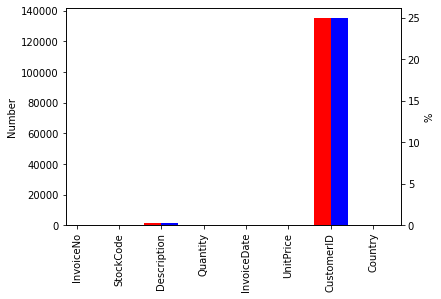

In [11]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
ax2 = ax.twinx()

width = 0.4

number_values = visual_info['null values (nb)'].plot(kind='bar', color='red', ax=ax, width=width, position=1, label='Number')
persent_values = visual_info['null values (%)'].plot(kind='bar', color='blue', ax=ax2, width=width, position=0, label='Percent')
plt.legend(handles=[number_values, persent_values])

ax.set_ylabel('Number')
ax2.set_ylabel('%')

plt.show()

In [12]:
display(df_initial[:5])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


While looking at the number of null values in the dataframe, it is interesting to note that $\sim$25% of the entries are not assigned to a particular customer. With the data available, it is impossible to impute values for the user and these entries are thus useless for the current exercise. So I delete them from the dataframe:


In [13]:
df_initial.dropna(axis = 0, subset = ['CustomerID'], inplace = True)
print('Dataframe dimensions:', df_initial.shape)
#____________________________________________________________
# gives some infos on columns types and numer of null values
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)

Dataframe dimensions: (406829, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int32,datetime64[ns],float64,float64,object
null values (nb),0,0,0,0,0,0,0,0
null values (%),0,0,0,0,0,0,0,0


In [14]:
print('Số bản ghi trùng lặp: {}'.format(df_initial.duplicated().sum()))
df_initial.drop_duplicates(inplace = True)

Số bản ghi trùng lặp: 5225


In [15]:
temp = df_initial[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
countries = temp['Country'].value_counts()
print('Số quốc gia: {}'.format(len(countries)))

Số quốc gia: 37


In [ ]:
import seaborn as sns
sns.pairplot(df_initial)